Loading data from block slider simulation...
Data loaded successfully.
Dataset shape: (5001, 4)
Time range: 0.0 to 5000.0 years
Number of data points: 5001

--- Physical Parameters ---
Spring Constant (k): 5.00e+05 Pa/m
Loading Rate (Vp): 1.00e-09 m/s
Friction Parameters: a=0.015, b=0.02, Dc=0.2 m
Normal Stress: 5.00e+07 Pa


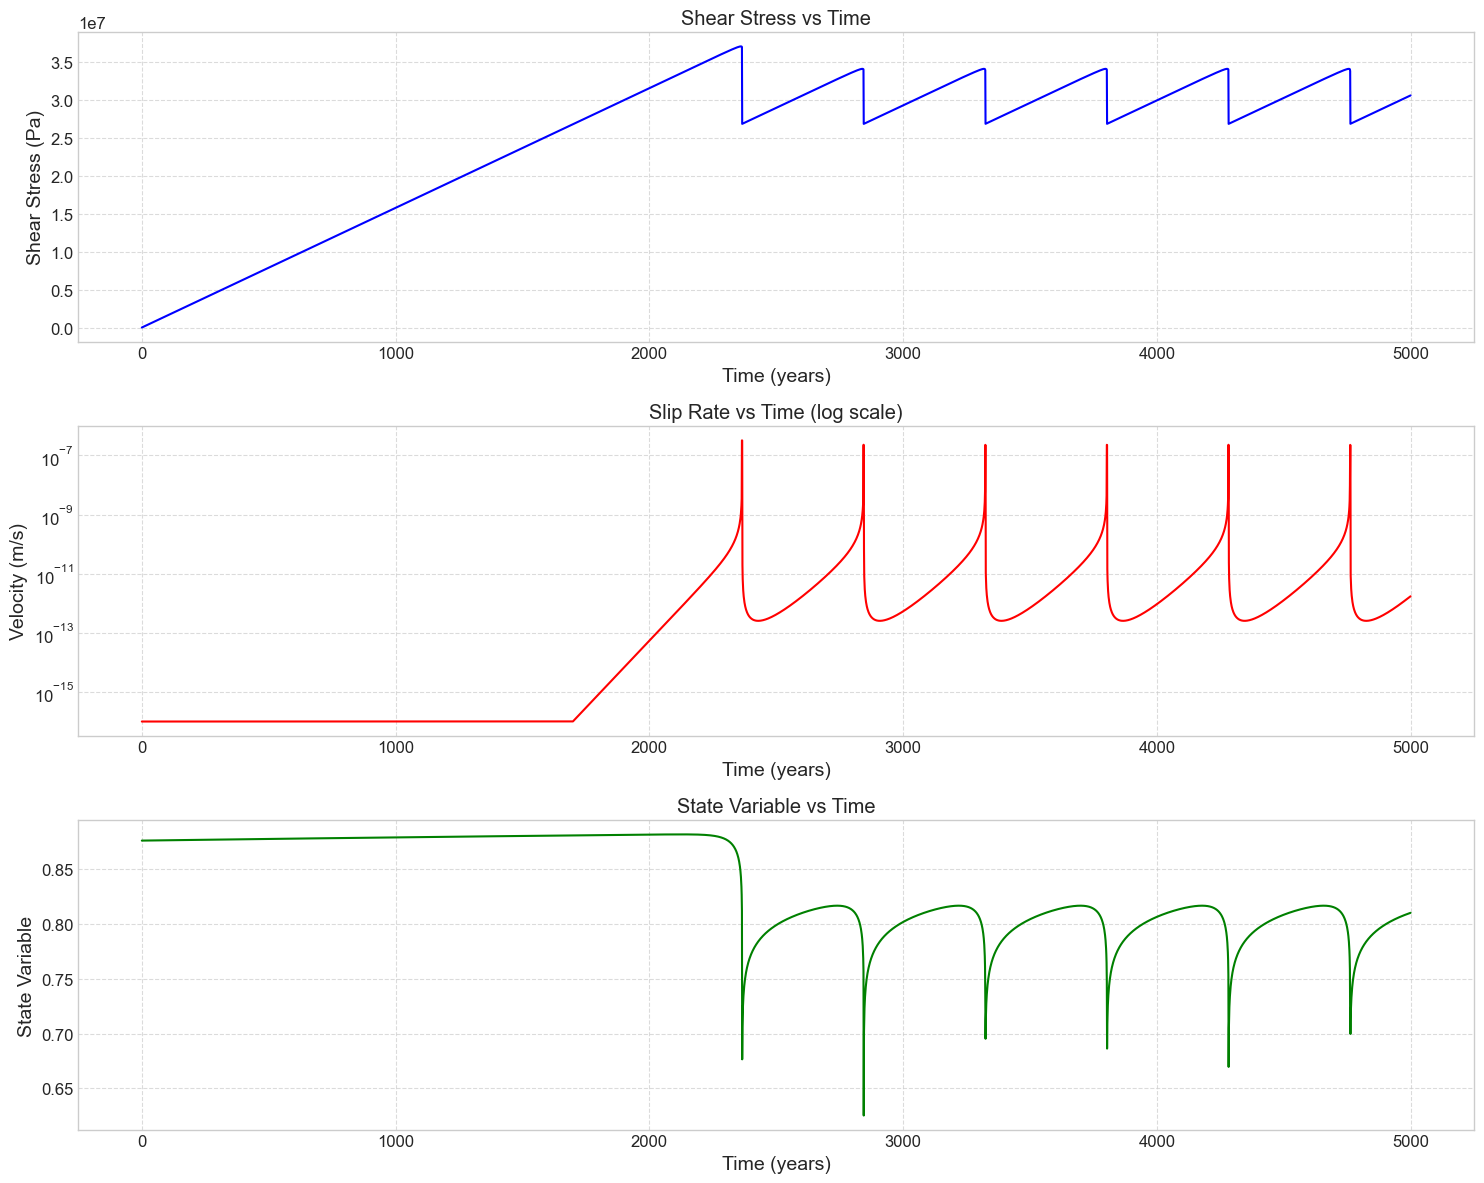

In [8]:
import os
import warnings
import numpy as np
from scipy import integrate
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import pysindy as ps
from pysindy.optimizers import STLSQ, SR3
from pysindy.feature_library import CustomLibrary, PolynomialLibrary

# Ignore specific warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set plot style for better-looking figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Create figures directory if it doesn't exist
os.makedirs('../figures', exist_ok=True)

print("Loading data from block slider simulation...")
# Load the data
try:
    # Use relative path assuming notebooks are in the "notebooks" directory
    X = np.load('../data/block_slider_data.npy')
    t = np.load('../data/block_slider_time.npy')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Data files not found. Trying alternative paths...")
    # Alternative loading paths
    try:
        X = np.load('data/block_slider_data.npy')
        t = np.load('data/block_slider_time.npy')
        print("Data loaded from alternative path.")
    except FileNotFoundError:
        print("Could not find data files. Please run the simulation notebook first.")
        # Create dummy data for testing
        print("Creating dummy data for testing...")
        t = np.linspace(0, 100, 1001)
        X = np.zeros((1001, 4))
        X[:, 0] = np.linspace(0, 1, 1001)  # Position
        X[:, 1] = 0.001 * np.ones(1001)    # Velocity
        X[:, 2] = 0.5 * np.ones(1001)      # State
        X[:, 3] = np.linspace(0, 1e6, 1001)  # Stress

# Extract individual variables and convert time to years
secs_per_year = 365 * 24 * 60 * 60
t_years = t / secs_per_year

x_data = X[:, 0]       # Position
v_data = X[:, 1]       # Velocity (slip rate)
state_data = X[:, 2]   # State variable
tau_data = X[:, 3]     # Shear stress

# Display basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Time range: {t_years[0]:.1f} to {t_years[-1]:.1f} years")
print(f"Number of data points: {len(t)}")

# Define physical parameters from the simulation for reference
sm = 3e10                  # Shear modulus (Pa)
density = 2700             # rock density (kg/m^3)
cs = np.sqrt(sm / density) # Shear wave speed (m/s)
eta = sm / (2 * cs)        # Radiation damping coefficient
L = 60 * 1000              # Width of plate boundary (m)
k = sm / L                 # Spring constant (Pa / m)
Vp = 1e-9                  # Rate of plate motion
sigma_n = 50e6             # Normal stress (Pa)
a = 0.015                  # Direct effect
b = 0.02                   # State weakening effect
Dc = 0.2                   # Critical distance
f0 = 0.6                   # Baseline friction coefficient
V0 = 1e-6                  # Reference velocity (m/s)

print("\n--- Physical Parameters ---")
print(f"Spring Constant (k): {k:.2e} Pa/m")
print(f"Loading Rate (Vp): {Vp:.2e} m/s")
print(f"Friction Parameters: a={a}, b={b}, Dc={Dc} m")
print(f"Normal Stress: {sigma_n:.2e} Pa")

# Plot the raw data with better formatting
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(t_years, tau_data, 'b-', linewidth=1.5)
plt.title('Shear Stress vs Time')
plt.xlabel('Time (years)')
plt.ylabel('Shear Stress (Pa)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(312)
plt.semilogy(t_years, v_data, 'r-', linewidth=1.5)
plt.title('Slip Rate vs Time (log scale)')
plt.xlabel('Time (years)')
plt.ylabel('Velocity (m/s)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(313)
plt.plot(t_years, state_data, 'g-', linewidth=1.5)
plt.title('State Variable vs Time')
plt.xlabel('Time (years)')
plt.ylabel('State Variable')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('../figures/raw_data.png', dpi=300)
plt.show()

In [9]:
# ----------------------------------------------------------------------------------
# Step 1: Using Raw Data Directly (No Preprocessing)
# ----------------------------------------------------------------------------------
print("\n--- Step 1: Using Raw Data Directly for SINDy ---")

# Use the raw data directly as recommended by the professor
X_preprocessed = X.copy()
print("Using raw data without preprocessing as recommended...")

# Feature names for the model
feature_names = ["x", "v", "state", "tau"]

# Compute derivatives using the finite difference method
print("Computing derivatives...")
try:
    # Try standard differentiation
    X_dot = ps.FiniteDifference().differentiate(X_preprocessed, t=t)
    print("Derivatives computed using standard method.")
except Exception as e:
    print(f"Standard differentiation failed: {e}")
    # Fall back to constant dt
    dt_median = np.median(np.diff(t))
    print(f"Using fallback method with median dt = {dt_median:.6e}")
    X_dot = ps.FiniteDifference()._differentiate(X_preprocessed, t=dt_median)
    print("Derivatives computed using fallback method.")

# Check for any NaN or infinity values in the derivatives
if np.any(~np.isfinite(X_dot)):
    print("Warning: Non-finite values in derivatives. Fixing...")
    X_dot = np.nan_to_num(X_dot, nan=0.0, posinf=0.0, neginf=0.0)

# Display derivatives statistics
print("\nDerivative statistics:")
for i, var_name in enumerate(['dx/dt', 'dv/dt', 'dstate/dt', 'dtau/dt']):
    print(f"{var_name}: min = {np.min(X_dot[:, i]):.2e}, max = {np.max(X_dot[:, i]):.2e}, "
          f"mean = {np.mean(X_dot[:, i]):.2e}, std = {np.std(X_dot[:, i]):.2e}")


--- Step 1: Using Raw Data Directly for SINDy ---
Using raw data without preprocessing as recommended...
Computing derivatives...
Standard differentiation failed: 'FiniteDifference' object has no attribute 'differentiate'
Using fallback method with median dt = 3.153600e+07
Derivatives computed using fallback method.

Derivative statistics:
dx/dt: min = 5.78e-38, max = 3.23e-07, mean = 6.12e-10, std = 1.20e-08
dv/dt: min = -5.13e-15, max = 5.10e-15, mean = 1.09e-23, std = 2.68e-16
dstate/dt: min = -2.38e-09, max = 1.43e-09, mean = -4.18e-13, std = 7.58e-11
dtau/dt: min = -1.61e-01, max = 5.00e-04, mean = 1.94e-04, std = 6.01e-03



--- Step 2: SINDy with Custom Rate-State Friction Library ---

Theoretical equations for reference:
x: dx/dt = v
state: dstate/dt = 1.000000e-07*(exp((f0-state)/b) - v/V0)
tau: dtau/dt = 5.000000e-04 - 5.000000e+05*v

Fitting SINDy with polynomial library only (for comparison)...
Identified equations (polynomial only):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = -0.017 1 + 0.021 state
Error with polynomial library: Values in t should be in strictly increasing order.

Fitting SINDy with custom rate-state friction library only...
Error with custom library: too many indices for array: array is 1-dimensional, but 2 were indexed

Fitting SINDy with combined library (custom + polynomial)...
Error with combined library: too many indices for array: array is 1-dimensional, but 2 were indexed

Trying different thresholds...
Using polynomial library for threshold search.

Trying threshold = 0.1...
Error with threshold 0.1: Values in t should be in strictly increasing order.

Trying thres

/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.005) and eliminated all 

Error with threshold 1e-05: Values in t should be in strictly increasing order.

Trying threshold = 1e-06...
Error with threshold 1e-06: Values in t should be in strictly increasing order.

Trying threshold = 1e-07...
Error with threshold 1e-07: Values in t should be in strictly increasing order.

Trying threshold = 1e-08...
Error with threshold 1e-08: Values in t should be in strictly increasing order.

Trying threshold = 1e-09...
Error with threshold 1e-09: Values in t should be in strictly increasing order.

Successfully created 1 models with different configurations.
Using polynomial as the best model.


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-07) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-08) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-09) and eliminated all coefficients
  warnings.warn(


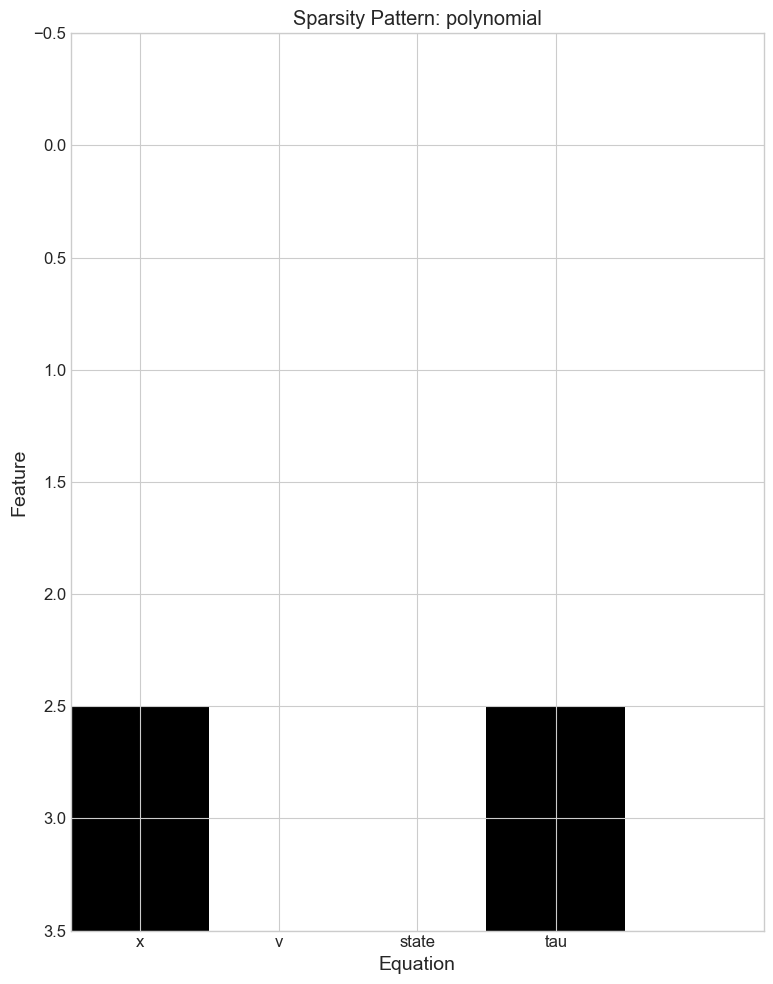


Comparison of identified vs. theoretical equations:
--------------------------------------------------------------------------------
x equation:
- Identified: 0.000
- Theoretical: dx/dt = v

state equation:
- Identified: 0.000
- Theoretical: dstate/dt = 1.000000e-07*(exp((f0-state)/b) - v/V0)

tau equation:
- Identified: -0.017 1 + 0.021 state
- Theoretical: dtau/dt = 5.000000e-04 - 5.000000e+05*v


Simulating with the best model...
Starting simulation...
Simulation completed successfully!


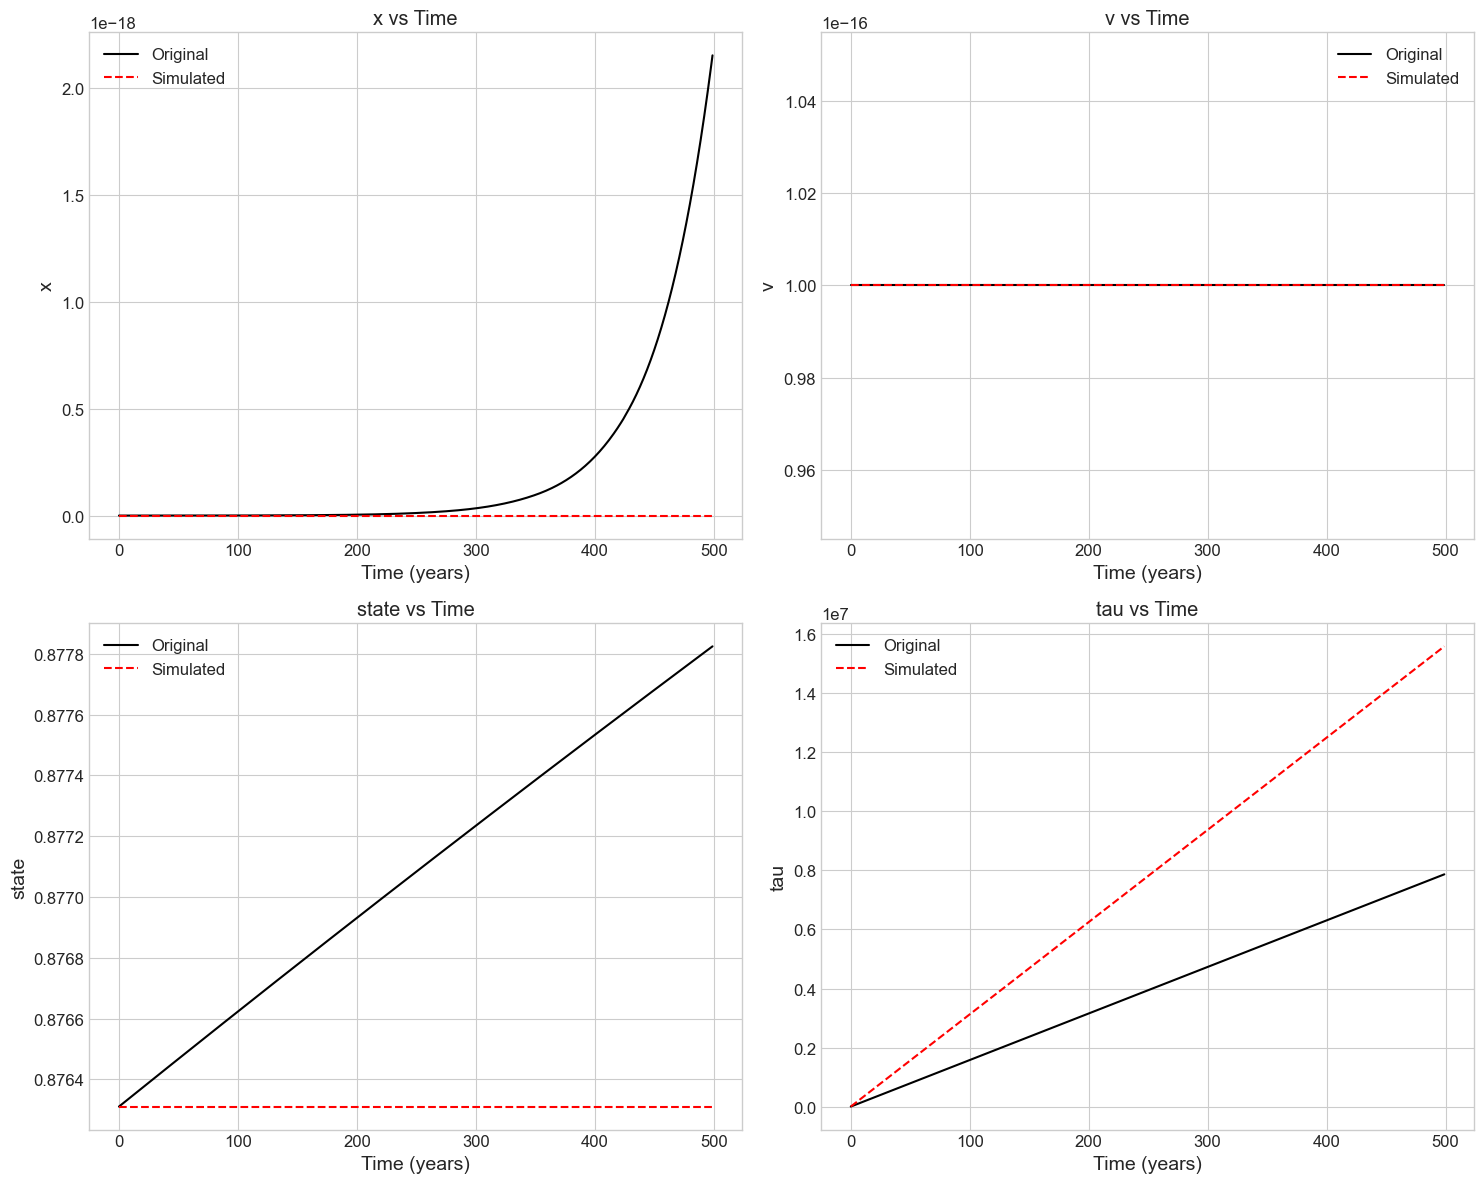

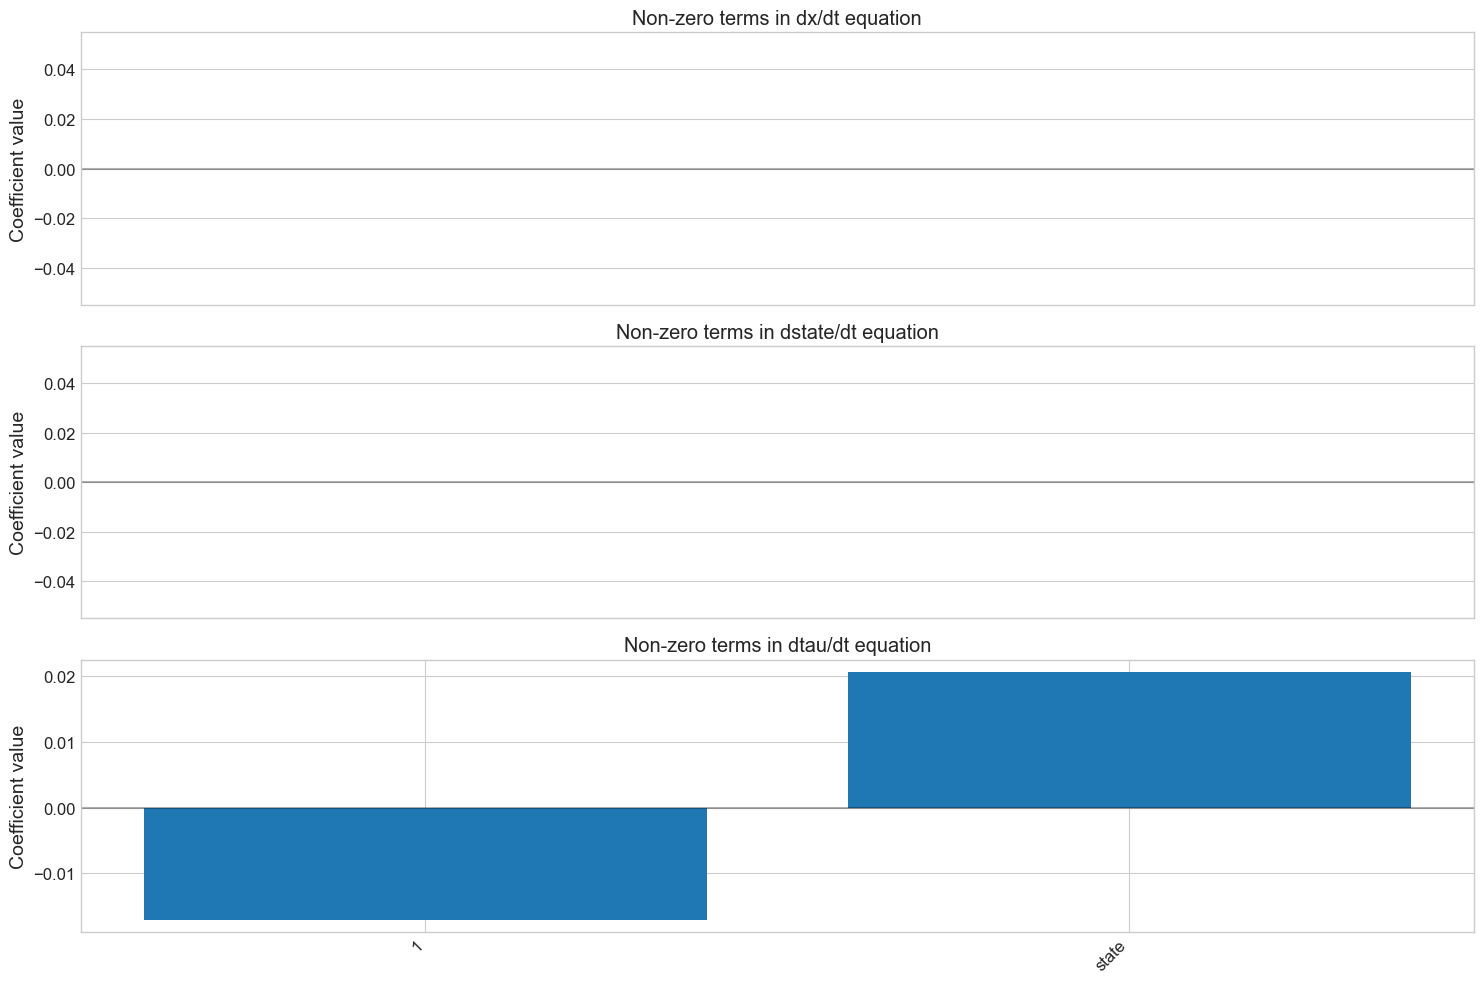


Analysis complete!


In [13]:
# ----------------------------------------------------------------------------------
# Step 2: SINDy with Custom Rate-State Friction Library
# ----------------------------------------------------------------------------------
print("\n--- Step 2: SINDy with Custom Rate-State Friction Library ---")

# Display theoretical equations for reference
print("\nTheoretical equations for reference:")
theoretical_eqs = {
    'x': "dx/dt = v",
    'state': f"dstate/dt = {b*V0/Dc:.6e}*(exp((f0-state)/b) - v/V0)",
    'tau': f"dtau/dt = {k*Vp:.6e} - {k:.6e}*v"
}
for var, eq in theoretical_eqs.items():
    print(f"{var}: {eq}")

# Define custom functions for rate-state friction equations with correct return shapes
def constant(x):
    """Constant term (1)"""
    return np.ones(x.shape[0])

def velocity(x):
    """Slip velocity (v)"""
    return x[:, 1]

def exp_state_term(x):
    """Term for exp((f0-state)/b) in state evolution"""
    return np.exp((f0-x[:, 2])/b)

def velocity_ratio(x):
    """Term for v/V0 in state evolution"""
    return (x[:, 1]/V0)

def loading_term(x):
    """Loading term k*Vp for stress evolution"""
    return np.ones(x.shape[0]) * k * Vp

def slip_term(x):
    """Slip term -k*v for stress evolution"""
    return -k * x[:, 1]

def state_evolution_term(x):
    """Complete state evolution term (b*V0/Dc)*(exp((f0-state)/b) - v/V0)"""
    return (b*V0/Dc) * (np.exp((f0-x[:, 2])/b) - x[:, 1]/V0)

# Your requested additional functions
def velocity_state_exp(x):
    """Calculate (V/(2*V0))*exp(state/a) term in rate-state friction"""
    v = x[:, 1]  # velocity
    state = x[:, 2]  # state variable
    return (v / (2 * V0)) * np.exp(state / a)

def arcsinh_velocity_state(x):
    """Calculate arcsinh((V/(2*V0))*exp(state/a)) term in rate-state friction"""
    v = x[:, 1]  # velocity
    state = x[:, 2]  # state variable
    inner_expr = (v / (2 * V0)) * np.exp(state / a)
    return np.arcsinh(inner_expr)

# Additional useful nonlinear functions
def sigmoid_velocity(x):
    """Sigmoid function of velocity 1/(1+exp(-v/V0))"""
    v = x[:, 1]
    return 1 / (1 + np.exp(-v/V0))

def tanh_velocity(x):
    """Hyperbolic tangent of velocity tanh(v/V0)"""
    v = x[:, 1]
    return np.tanh(v/V0)

def sign_velocity(x):
    """Sign of velocity"""
    v = x[:, 1]
    return np.sign(v)

def ln_velocity(x):
    """Natural log of velocity (with safety for small values)"""
    v = np.clip(np.abs(x[:, 1]), 1e-10, None)  # Prevent log(0)
    return np.log(v/V0)

def tau_state_interaction(x):
    """Interaction between stress and state variable"""
    tau = x[:, 3]
    state = x[:, 2]
    return tau * state

# Combine all functions into the library
functions = [
    constant,
    velocity,
    exp_state_term, 
    velocity_ratio,
    loading_term,
    slip_term,
    state_evolution_term,
    velocity_state_exp,
    arcsinh_velocity_state,
    sigmoid_velocity,
    tanh_velocity,
    sign_velocity,
    ln_velocity,
    tau_state_interaction
]

function_names = [
    '1', 
    'v', 
    'exp((f0-state)/b)', 
    'v/V0', 
    'k*Vp', 
    '-k*v',
    '(b*V0/Dc)*(exp((f0-state)/b) - v/V0)',
    '(v/(2*V0))*exp(state/a)',
    'arcsinh((v/(2*V0))*exp(state/a))',
    'sigmoid(v/V0)',
    'tanh(v/V0)',
    'sign(v)',
    'ln(v/V0)',
    'tau*state'
]

# Create the custom library
custom_lib = CustomLibrary(
    library_functions=functions,
    function_names=function_names
)

# Create a polynomial library as well - keep it simple
poly_lib = PolynomialLibrary(degree=1, include_bias=True)

# Combine the libraries
combined_lib = custom_lib + poly_lib

# Store models
models = {}

# Try with polynomial-only library first (for comparison)
print("\nFitting SINDy with polynomial library only (for comparison)...")
# Remove the normalize parameter since it's not supported in your version
optimizer_poly = STLSQ(threshold=1e-2)
model_poly = ps.SINDy(
    optimizer=optimizer_poly,
    feature_library=poly_lib,
    feature_names=feature_names
)

try:
    model_poly.fit(X_preprocessed, x_dot=X_dot, t=None)
    models["polynomial"] = model_poly
    print("Identified equations (polynomial only):")
    model_poly.print()
    poly_score = model_poly.score(X_preprocessed, X_dot)
    print(f"Polynomial model score (R²): {poly_score:.4f}")
except Exception as e:
    print(f"Error with polynomial library: {e}")

# Try with custom library only
print("\nFitting SINDy with custom rate-state friction library only...")
optimizer_custom = STLSQ(threshold=1e-2)  # Remove normalize parameter
model_custom = ps.SINDy(
    optimizer=optimizer_custom,
    feature_library=custom_lib,
    feature_names=feature_names
)

try:
    model_custom.fit(X_preprocessed, x_dot=X_dot, t=None)
    models["custom"] = model_custom
    print("Identified equations (custom library):")
    model_custom.print()
    custom_score = model_custom.score(X_preprocessed, X_dot)
    print(f"Custom library model score (R²): {custom_score:.4f}")
except Exception as e:
    print(f"Error with custom library: {e}")

# Try with combined library
print("\nFitting SINDy with combined library (custom + polynomial)...")
optimizer_combined = STLSQ(threshold=1e-2)  # Remove normalize parameter
model_combined = ps.SINDy(
    optimizer=optimizer_combined,
    feature_library=combined_lib,
    feature_names=feature_names
)

try:
    model_combined.fit(X_preprocessed, x_dot=X_dot, t=None)
    models["combined"] = model_combined
    print("Identified equations (combined library):")
    model_combined.print()
    combined_score = model_combined.score(X_preprocessed, X_dot)
    print(f"Combined library model score (R²): {combined_score:.4f}")
except Exception as e:
    print(f"Error with combined library: {e}")

# Try different thresholds with the best library (based on what worked above)
print("\nTrying different thresholds...")
best_lib = None
if "combined" in models:
    best_lib = combined_lib
    print("Using combined library for threshold search.")
elif "custom" in models:
    best_lib = custom_lib
    print("Using custom library for threshold search.")
else:
    best_lib = poly_lib
    print("Using polynomial library for threshold search.")

thresholds = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
best_score = float('-inf')
best_threshold = None
best_model = None

if best_lib is not None:
    for threshold in thresholds:
        print(f"\nTrying threshold = {threshold}...")
        optimizer = STLSQ(threshold=threshold)  # Remove normalize parameter
        model = ps.SINDy(
            optimizer=optimizer,
            feature_library=best_lib,
            feature_names=feature_names
        )
        
        try:
            model.fit(X_preprocessed, x_dot=X_dot, t=None)
            
            # Calculate score
            score = model.score(X_preprocessed, X_dot)
            num_active_terms = np.count_nonzero(model.coefficients())
            
            print(f"Identified equations (threshold={threshold}):")
            model.print()
            print(f"Score: {score:.4f}, Active terms: {num_active_terms}")
            
            # Store model
            models[f"threshold_{threshold}"] = model
            
            # Update best model if score is better
            if score > best_score:
                best_score = score
                best_threshold = threshold
                best_model = model
                print(f"New best model found! Score: {score:.4f}")
        except Exception as e:
            print(f"Error with threshold {threshold}: {e}")

# Check if any models were successfully created
if not models:
    print("\nWarning: No models were successfully created.")
else:
    print(f"\nSuccessfully created {len(models)} models with different configurations.")
    
    # Use best model for further analysis
    if best_model is None:
        # If no best model from threshold search, use the combined model if available
        if "combined" in models:
            best_model = models["combined"]
            print("Using combined library model as the best model.")
        elif "custom" in models:
            best_model = models["custom"]
            print("Using custom library model as the best model.")
        else:
            best_model = next(iter(models.values()))
            print(f"Using {next(iter(models.keys()))} as the best model.")
    else:
        print(f"Using model with threshold={best_threshold} as the best model. Score: {best_score:.4f}")
    
    # Create a visual of the sparsity patterns
    plt.figure(figsize=(15, 10))
    
    model_names = list(models.keys())
    nrows = (len(model_names) + 1) // 2
    
    for i, name in enumerate(model_names):
        plt.subplot(nrows, 2, i+1)
        coefs = models[name].coefficients()
        plt.imshow(np.abs(coefs) > 1e-6, cmap='binary', aspect='auto')
        plt.title(f'Sparsity Pattern: {name}')
        plt.xlabel('Equation')
        plt.ylabel('Feature')
        plt.xticks(range(len(feature_names)), feature_names)
    
    plt.tight_layout()
    plt.savefig('../figures/sparsity_comparison.png', dpi=300)
    plt.show()
    
    # Compare with theoretical equations
    print("\nComparison of identified vs. theoretical equations:")
    print("-" * 80)
    
    for i, var in enumerate(feature_names):
        if var in theoretical_eqs:
            print(f"{var} equation:")
            print(f"- Identified: {best_model.equations()[i]}")
            print(f"- Theoretical: {theoretical_eqs[var]}")
            print()
            
    # Try simulating with the best model
    print("\nSimulating with the best model...")
    
    try:
        # Initial condition (first point in data)
        x0 = X_preprocessed[0, :]
        
        # Simulate for a portion of the original time
        t_sim = t[:500]  # Use fewer points to reduce simulation time
        print("Starting simulation...")
        x_sim = best_model.simulate(x0, t_sim)
        print("Simulation completed successfully!")
        
        # Plot simulation vs. original data
        plt.figure(figsize=(15, 12))
        
        for i, var in enumerate(feature_names):
            plt.subplot(2, 2, i+1)
            plt.plot(t_sim/secs_per_year, X_preprocessed[:500, i], 'k-', label='Original')
            plt.plot(t_sim/secs_per_year, x_sim[:, i], 'r--', label='Simulated')
            plt.title(f'{var} vs Time')
            plt.xlabel('Time (years)')
            plt.ylabel(f'{var}')
            plt.legend()
            plt.grid(True)
            
        plt.tight_layout()
        plt.savefig('../figures/simulation_results.png', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error during simulation: {e}")

    # Create a visual comparison of the equations
    plt.figure(figsize=(15, 10))
    
    for i, var in enumerate(['x', 'state', 'tau']):
        # Get coefficients for this variable
        idx = feature_names.index(var)
        coefs = best_model.coefficients()[idx]
        feature_names_model = best_model.get_feature_names()
        
        # Only show non-zero coefficients
        mask = np.abs(coefs) > 1e-5
        terms = [feature_names_model[j] for j, m in enumerate(mask) if m]
        values = [coefs[j] for j, m in enumerate(mask) if m]
        
        # Plot
        ax = plt.subplot(3, 1, i+1)
        bars = ax.bar(range(len(terms)), values, tick_label=terms)
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax.set_title(f'Non-zero terms in d{var}/dt equation')
        ax.set_ylabel('Coefficient value')
        
        # Color-code bars to highlight the most important terms from theory
        for j, term in enumerate(terms):
            if (var == 'x' and term == 'v') or \
               (var == 'state' and ('exp(' in term or 'v/V0' in term)) or \
               (var == 'tau' and (term == '-k*v' or term == 'k*Vp')):
                bars[j].set_color('r')
        
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('../figures/equation_comparison.png', dpi=300)
    plt.show()

print("\nAnalysis complete!")